## Data preperation

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

#set the font
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'


In [35]:
wos = pd.read_csv('savedrecs_4.csv')
scopus = pd.read_csv('scopus_4.csv')

In [36]:
scopus.dtypes

Authors               object
Author full names     object
Author(s) ID          object
Title                 object
Year                   int64
Source title          object
Volume                object
Issue                 object
Art. No.              object
Page start            object
Page end              object
Page count           float64
Cited by               int64
DOI                   object
Link                  object
Abstract              object
Author Keywords       object
Index Keywords        object
Document Type         object
Publication Stage     object
Open Access           object
Source                object
EID                   object
dtype: object

In [37]:
#only select relevant columns from datasets
wos_sel = wos[['Publication Type', 'Article Title', 'Author Keywords', 'Keywords Plus', 'Abstract', 'DOI', 'Publication Year']]
scopus_sel = scopus[['Title', 'Abstract', 'Author Keywords', 'Index Keywords', 'Document Type', 'DOI', 'Year']]


In [38]:
#rename columns 
wos_sel = wos_sel.rename(columns={
    'Publication Type': 'Document Type',
    'Article Title': 'Title',
    'Author Keywords': 'Author Keywords',
    'Publication Year' : 'Year',
})


In [39]:
print("Duplicates in wos_sel DOI:", wos_sel['DOI'].duplicated().sum())
print("Duplicates in scopus_sel DOI:", scopus_sel['DOI'].duplicated().sum())

Duplicates in wos_sel DOI: 17
Duplicates in scopus_sel DOI: 20


In [40]:
#remove duplicates based on DOI
wos_sel = wos_sel.drop_duplicates(subset=['DOI'])
scopus_sel = scopus_sel.drop_duplicates(subset=['DOI'])

print(len(scopus_sel))
print(len(wos_sel))

181
370


In [41]:
#merge data frames
merged_df = pd.merge(wos_sel, scopus_sel, on='DOI', how = 'outer', suffixes=('_wos', '_scopus'))

In [42]:
merged_df

,Document Type_wos,Title_wos,Author Keywords_wos,Keywords Plus,Abstract_wos,DOI,Year_wos,Title_scopus,Abstract_scopus,Author Keywords_scopus,Index Keywords,Document Type_scopus,Year_scopus
0,C,Responsible AI Tutorial,Explainable AI; Responsible AI; Machine Learni...,NaN,There is rapid technical progress and widespre...,10.1145/3493700.3493769,2022.0,Responsible AI Tutorial,There is rapid technical progress and widespre...,Explainable AI; Machine Learning Operations; R...,Advertizing; Business activities; Explainable ...,Conference paper,2022.0
1,C,RESPONSIBLE AI FOR EARTH OBSERVATION: ATTITIDE...,Responsible AI; RAI; AI guidelines; AI4EO; RAI4EO,NaN,As AI permeates industries and reaches the gen...,10.1109/IGARSS52108.2023.10282983,2023.0,Responsible AI for Earth Observation: Attitide...,As AI permeates industries and reaches the gen...,AI guidelines; AI4EO; RAI; RAI4EO; Responsible AI,NaN,Conference paper,2023.0
2,C,It is currently hodgepodge: Examining AI/ML Pr...,Responsible AI; RAI; ethical AI; value levers;...,ETHICS; FAIRNESS; SCIENCE; DESIGN,"Recently, the AI/ML research community has ind...",10.1145/3544548.3580903,2023.0,"""It is currently hodgepodge"": Examining AI/ML ...","Recently, the AI/ML research community has ind...",accountability; co-production; collaboration; ...,Life cycle; Accountability; Co-production; Col...,Conference paper,2023.0
3,J,Connecting the dots in trustworthy Artificial ...,Trustworthy AI; AI ethics; Responsible AI syst...,BIG DATA; FRAMEWORK; QUALITY; PRIVACY; METRICS,Trustworthy Artificial Intelligence (AI) is ba...,10.1016/j.inffus.2023.101896,2023.0,Connecting the dots in trustworthy Artificial ...,Trustworthy Artificial Intelligence (AI) is ba...,AI ethics; AI regulation; Regulatory sandbox; ...,Ethical technology; Life cycle; Artificial int...,Article,2023.0
4,J,Incorporating FAT and privacy aware AI modelin...,Explainable AI; Fairness; Transparency; Accoun...,SYSTEMS,We present a formal approach to build and eval...,10.1016/j.dss.2021.113715,2022.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,NaN,NaN,NaN,NaN,NaN,10.1007/978-3-030-77857-6_18,NaN,Designing Ethical Agency for Adaptive Instruct...,Adaptive Instructional Systems (AIS) have the ...,Adaptive instructional systems; Ethical AI; FA...,Adaptive systems; Automatic identification; Co...,Conference paper,2021.0
459,NaN,NaN,NaN,NaN,NaN,10.1007/978-981-99-7093-3_12,NaN,Explainable AI for Black Sigatoka Detection,Banana plants are susceptible to the dangerous...,Black sigatoka; Convolutional neural network (...,Decision making; Diagnosis; Fruits; Lime; Bana...,Conference paper,2023.0
460,NaN,NaN,NaN,NaN,NaN,10.18690/978-961-286-485-9.43,NaN,RESPONSIBLE AI AND POWER: INVESTIGATING THE SY...,Numerous statements and pamphlets indicate tha...,algorithms; business rules management; street ...,Decision trees; Laws and legislation; Business...,Conference paper,2021.0
461,NaN,NaN,NaN,NaN,NaN,10.1109/ISTAS55053.2022.10227139,NaN,Inexplicable AI in Medicine as a Form of Epist...,This contribution portrays inexplicable AI in ...,Epistemic Oppression; Explainable AI; Explicab...,Decision-making process; Epistemic oppression;...,Conference paper,2022.0


In [43]:
#fill in missing values for document type

merged_df['Document Type_scopus'] = merged_df.apply(
    lambda row: 'Conference paper' if pd.isna(row['Document Type_scopus']) and row['Document Type_wos'] == 'C' else (
                'Article' if pd.isna(row['Document Type_scopus']) and row['Document Type_wos'] == 'J' else row['Document Type_scopus']),
    axis=1
)

In [44]:
#fill in missing values for abstract

merged_df['Abstract_scopus'] = merged_df.apply(
    lambda row: row['Abstract_wos'] if pd.isna(row['Abstract_scopus']) else row['Abstract_scopus'],
    axis=1
)

In [45]:
#fill in missing values for year

merged_df['Year_scopus'] = merged_df.apply(
    lambda row: row['Year_wos'] if pd.isna(row['Year_scopus']) else row['Year_scopus'],
    axis=1
)

In [46]:
filtered_df = merged_df[merged_df['Document Type_scopus'] == 'Article']

In [47]:
print(len(filtered_df))

251


## Descriptive graphs

In [48]:

def check_keywords(df, keyword):
    columns_to_check = [
        'Author Keywords_wos', 
        'Author Keywords_scopus', 
        'Index Keywords',
        'Keywords Plus',
        'Abstract_scopus',
        'Abstract_wos'
]
    
    df[f'mentions_{keyword}'] = False
    
    for col in columns_to_check:
        if col in df.columns:  
            df[f'mentions_{keyword}_{col}'] = df[col].str.contains(keyword, na=False, case=False)
            df[f'mentions_{keyword}'] = df[f'mentions_{keyword}'] | df[f'mentions_{keyword}_{col}']


keywords = ['fairness', 'accountability', 'cybersecurity', 'transparency']

for keyword in keywords:
    check_keywords(filtered_df, keyword)


/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/417636677.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'mentions_{keyword}'] = False
/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/417636677.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'mentions_{keyword}_{col}'] = df[col].str.contains(keyword, na=False, case=False)
/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/417636677.py:16: SettingWithCopyWarning: 
A value is trying to be set on a

In [49]:
filtered_df

,Document Type_wos,Title_wos,Author Keywords_wos,Keywords Plus,Abstract_wos,DOI,Year_wos,Title_scopus,Abstract_scopus,Author Keywords_scopus,...,mentions_cybersecurity_Keywords Plus,mentions_cybersecurity_Abstract_scopus,mentions_cybersecurity_Abstract_wos,mentions_transparency,mentions_transparency_Author Keywords_wos,mentions_transparency_Author Keywords_scopus,mentions_transparency_Index Keywords,mentions_transparency_Keywords Plus,mentions_transparency_Abstract_scopus,mentions_transparency_Abstract_wos
3,J,Connecting the dots in trustworthy Artificial ...,Trustworthy AI; AI ethics; Responsible AI syst...,BIG DATA; FRAMEWORK; QUALITY; PRIVACY; METRICS,Trustworthy Artificial Intelligence (AI) is ba...,10.1016/j.inffus.2023.101896,2023.0,Connecting the dots in trustworthy Artificial ...,Trustworthy Artificial Intelligence (AI) is ba...,AI ethics; AI regulation; Regulatory sandbox; ...,...,False,False,False,True,False,False,False,False,True,True
4,J,Incorporating FAT and privacy aware AI modelin...,Explainable AI; Fairness; Transparency; Accoun...,SYSTEMS,We present a formal approach to build and eval...,10.1016/j.dss.2021.113715,2022.0,NaN,We present a formal approach to build and eval...,NaN,...,False,False,False,True,True,False,False,False,True,True
6,C,Towards Responsible AI for Financial Transactions,Al in Finance; Explainable AI; Feature Salienc...,NaN,The application of AI in finance is increasing...,NaN,2020.0,Use of ai for climate change : Modelling the b...,This study is of prominent importance in the p...,Artificial Intelligence; Climate Change; Energ...,...,False,False,False,True,False,False,False,False,True,True
7,J,Towards a deliberative framework for responsib...,Artificial intelligence; AI governance; Accoun...,GRAND CHALLENGES; LEGITIMACY; MANAGEMENT; DISC...,The rapid innovation in artificial intelligenc...,10.1016/j.techsoc.2020.101475,2021.0,Towards a deliberative framework for responsib...,The rapid innovation in artificial intelligenc...,Accountability; AI governance; Artificial inte...,...,False,False,False,True,True,True,False,False,True,True
8,J,Humanizing AI in medical training: ethical fra...,human-AI interaction; Human-Computer Interacti...,NaN,The increasing use of artificial intelligence ...,10.3389/frai.2023.1189914,2023.0,NaN,The increasing use of artificial intelligence ...,NaN,...,False,False,False,True,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438,NaN,NaN,NaN,NaN,NaN,10.29379/jedem.v14i1.678,NaN,Responsible Artificial Intelligence in Governm...,Various international guideline documents sugg...,algorithm; Artificial intelligence; automated ...,...,False,False,False,True,False,False,False,False,True,False
443,NaN,NaN,NaN,NaN,NaN,10.1145/3476049,NaN,Data Subjects' Conceptualizations of and Attit...,Automatic emotion recognition (ER)-enabled wel...,affect recognition; affective computing; AI et...,...,False,False,False,False,False,False,False,False,False,False
451,NaN,NaN,NaN,NaN,NaN,10.31857/S023620070026109-6,NaN,AI in Health Ethical Review: A Value Design Me...,"As our world becomes more dependent on data, a...",6 principles of AI; artificial intelligence; b...,...,False,False,False,True,False,False,False,False,True,False
456,NaN,NaN,NaN,NaN,NaN,10.1145/3555760,NaN,Understanding Machine Learning Practitioners' ...,Data is central to the development and evaluat...,datasets; documentation; machine learning; res...,...,False,False,False,True,False,False,False,False,True,False


In [50]:
summary = filtered_df[['mentions_transparency', 'mentions_fairness', 'mentions_accountability', 'mentions_cybersecurity']].sum()
print(summary)

mentions_transparency      133
mentions_fairness           93
mentions_accountability     91
mentions_cybersecurity      14
dtype: int64


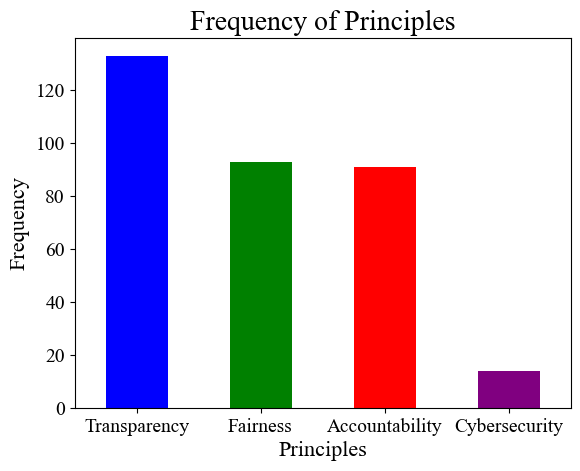

In [51]:
#create a bar plot with frequencies
summary.plot(kind='bar', color=['blue', 'green', 'red', 'purple'])

plt.title('Frequency of Principles', fontsize = 20)
plt.xlabel('Principles', fontsize = 16)
plt.ylabel('Frequency', fontsize=16)
plt.xticks(ticks = range(4), labels = ['Transparency', 'Fairness', 'Accountability', 'Cybersecurity'], rotation=0, fontsize=14) 
plt.yticks(fontsize=14)

plt.savefig('frequency_of_principles_filtered.png')  


plt.show()



In [52]:
filtered_df['num_principles_mentioned'] = (filtered_df['mentions_transparency'] +
                                         filtered_df['mentions_fairness'] +
                                         filtered_df['mentions_accountability'] +
                                         filtered_df['mentions_cybersecurity'])

principles_count = filtered_df['num_principles_mentioned'].value_counts().sort_index()

/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/3742819686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['num_principles_mentioned'] = (filtered_df['mentions_transparency'] +


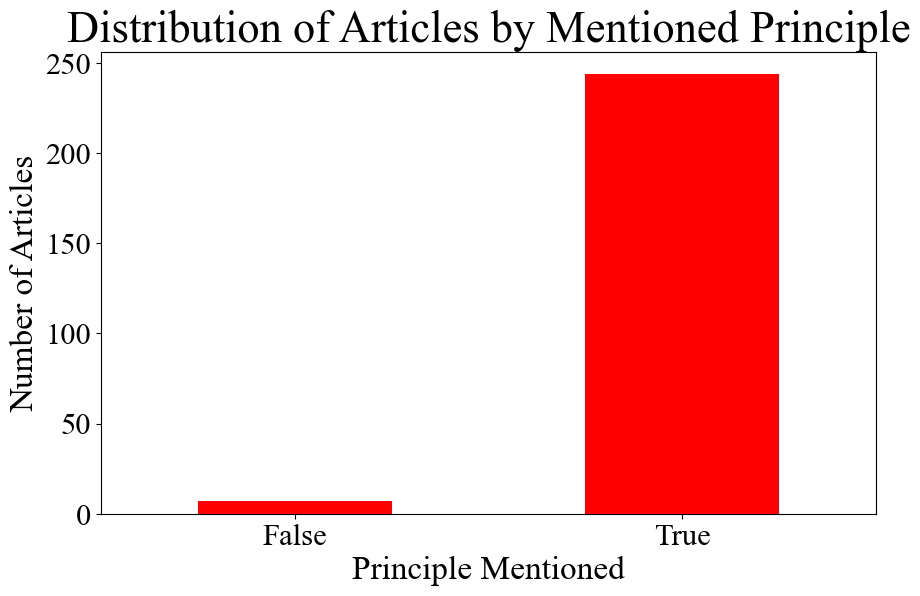

In [53]:
#create bar plot with distribution of articles
principles_count.plot(kind='bar', color='red', figsize=(10, 6))

plt.title('Distribution of Articles by Mentioned Principle', fontsize = 32)
plt.xlabel('Principle Mentioned', fontsize = 24)
plt.ylabel('Number of Articles', fontsize = 24)
plt.xticks(rotation=0, fontsize = 22)  
plt.yticks(rotation=0, fontsize = 22)  


plt.savefig('principle_mentioned_filtered.png')  

plt.show()



In [54]:
#export articles with no principles for analyis
no_principle_articles = filtered_df[filtered_df['num_principles_mentioned'] == 0]
filtered_df = filtered_df[filtered_df['num_principles_mentioned'] != 0]
filtered_df.to_csv('dataset_2105_merged.csv')

In [55]:
#create csv of articles not mentioning principles
no_principle_articles.to_csv('no_principle_articles.csv', index=False)


/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/3417728107.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['principles_combination'] = filtered_df.apply(


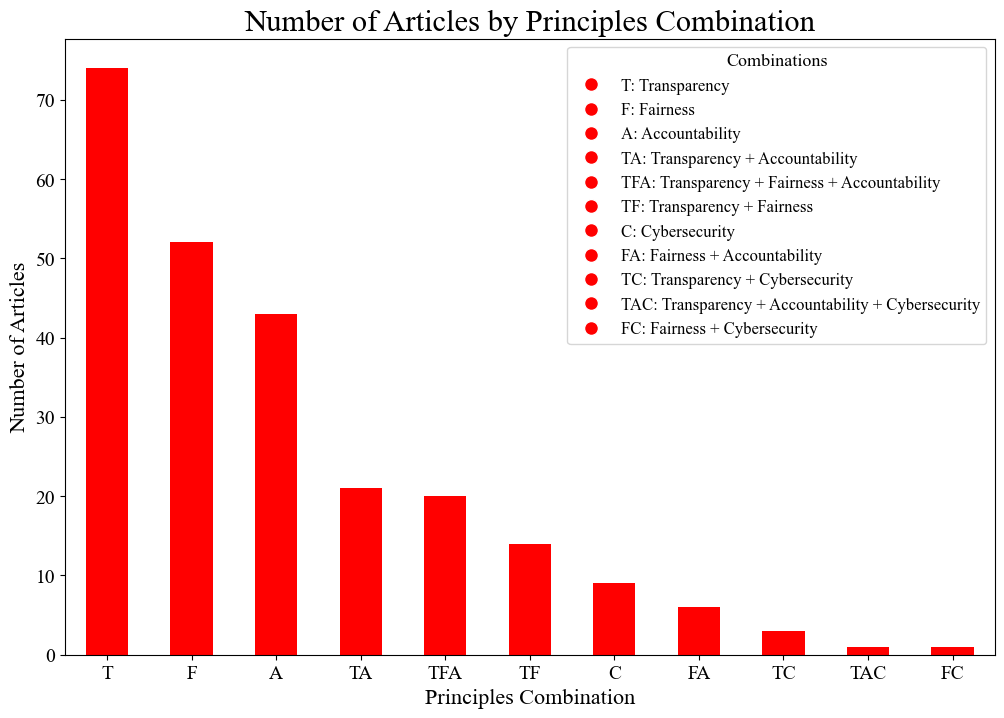

In [56]:
#Create plot with all principles and their combinations
filtered_df['principles_combination'] = filtered_df.apply(
    lambda x: f"{'T' if x['mentions_transparency'] else ''}"
              f"{'F' if x['mentions_fairness'] else ''}"
              f"{'A' if x['mentions_accountability'] else ''}"
              f"{'C' if x['mentions_cybersecurity'] else ''}",
    axis=1
)

combination_count = filtered_df['principles_combination'].value_counts().sort_values(ascending=False)

#plotting the result
combination_count.plot(kind='bar', color='red', figsize=(12, 8))

#adding titles and labels
plt.title('Number of Articles by Principles Combination', fontsize = 22)
plt.xlabel('Principles Combination', fontsize = 16)
plt.ylabel('Number of Articles', fontsize = 16)
plt.xticks(rotation=0, fontsize = 14) 
plt.yticks(rotation=0, fontsize = 14) 

#adding a legend with all possible combinations
all_combinations = {
    'T': 'T: Transparency', 'F': 'F: Fairness', 'A': 'A: Accountability', 'C': 'C: Cybersecurity',
    'TF': 'TF: Transparency + Fairness', 'TA': 'TA: Transparency + Accountability', 'TC': 'TC: Transparency + Cybersecurity',
    'FA': 'FA: Fairness + Accountability', 'FC': 'FC: Fairness + Cybersecurity', 'AC': 'AC: Accountability + Cybersecurity',
    'TFA': 'TFA: Transparency + Fairness + Accountability', 'TFC': 'TFC: Transparency + Fairness + Cybersecurity',
    'TAC': 'TAC: Transparency + Accountability + Cybersecurity', 'FAC': 'FAC: Fairness + Accountability + Cybersecurity',
    'TFAC': 'TFAC: Transparency + Fairness + Accountability + Cybersecurity'
}

displayed_combinations = combination_count.index.tolist()
legend_labels = [all_combinations.get(comb, 'No principle') for comb in displayed_combinations]

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label=comb) for comb in displayed_combinations]
plt.legend(handles, legend_labels, title='Combinations', fontsize=12, title_fontsize='13')


plt.savefig('number_of_articles_per_combi_filtered.png')  
plt.show()



In [57]:
print(combination_count)

principles_combination
T      74
F      52
A      43
TA     21
TFA    20
TF     14
C       9
FA      6
TC      3
TAC     1
FC      1
Name: count, dtype: int64


In [58]:
summary_type = filtered_df[['Document Type_scopus']].value_counts()
print(summary_type)

Document Type_scopus
Article                 244
Name: count, dtype: int64


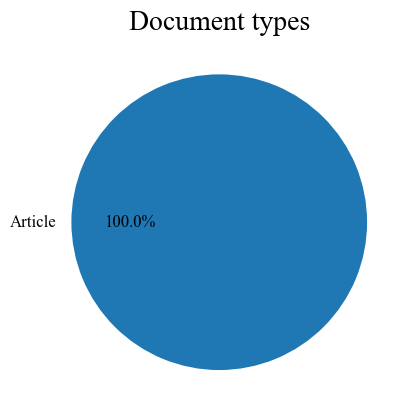

In [59]:
#inspect if all document types are articles
summary_type.index = summary_type.index.map(lambda x: ', '.join(x) if isinstance(x, tuple) else x)
summary_type.plot(kind='pie', labels=summary_type.index, autopct= '%1.1f%%', fontsize= 12)
plt.title('Document types', fontsize = 20)
plt.ylabel('')
plt.savefig('document_types_filtered.png')  

plt.show()


In [60]:
#get numbers of publications per year
filtered_df['Year_scopus'] = filtered_df['Year_scopus'].astype(int).astype(str)
summary_year = filtered_df['Year_scopus'].value_counts()
summary_year = summary_year.sort_index()
print(summary_year)

Year_scopus
2019      5
2020     10
2021     28
2022     43
2023    103
2024     55
Name: count, dtype: int64


/var/folders/4p/tsjjr0tn0q1_wft24kdmqtn40000gn/T/ipykernel_1071/277043289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year_scopus'] = filtered_df['Year_scopus'].astype(int).astype(str)


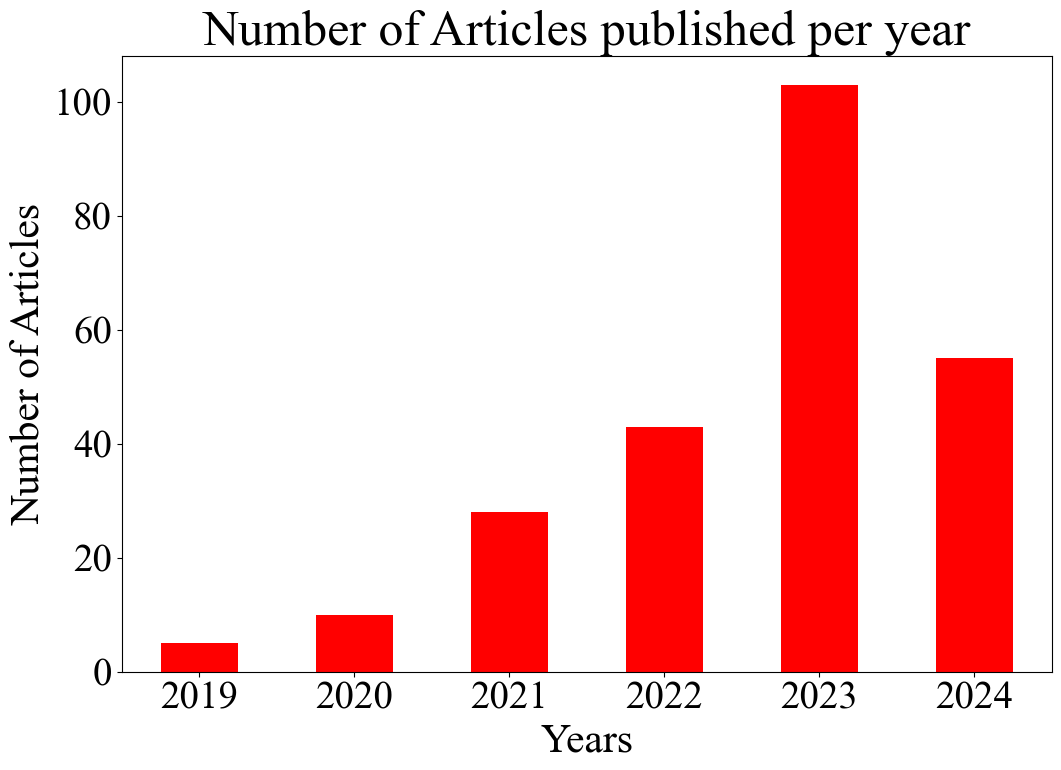

In [61]:
#create barplot with publications per year
summary_year.plot(kind='bar', color='red', figsize=(12, 8))

#adding titles and labels
plt.title('Number of Articles published per year', fontsize=36)
plt.xlabel('Years', fontsize = 30)
plt.ylabel('Number of Articles', fontsize = 30)
plt.xticks(rotation=0, fontsize = 28) 
plt.yticks(rotation=0, fontsize = 28)
plt.savefig('number_of_articles_per_year_filtered.png')  

plt.show()

